In [1]:
%load_ext autoreload
%matplotlib inline

import os
from pathlib import Path
from tempfile import TemporaryDirectory

import numpy as np
import nibabel as nb

# cwd = TemporaryDirectory()
# os.chdir(cwd.name)
# print(os.getcwd())

/tmp/tmpjpz2cffb


In [2]:
!wget https://nipy.org/nibabel/_downloads/someones_anatomy.nii.gz

--2019-03-22 11:32:33--  https://nipy.org/nibabel/_downloads/someones_anatomy.nii.gz
Resolving nipy.org (nipy.org)... 185.199.111.153, 185.199.110.153, 185.199.108.153, ...
Connecting to nipy.org (nipy.org)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191449 (187K) [application/gzip]
Saving to: ‘someones_anatomy.nii.gz’

someones_anatomy.ni 100%[===================>] 186.96K  --.-KB/s    in 0.007s  

2019-03-22 11:32:33 (26.6 MB/s) - ‘someones_anatomy.nii.gz’ saved [191449/191449]



<OrthoSlicer3D: someones_anatomy.nii.gz (57, 67, 56)>

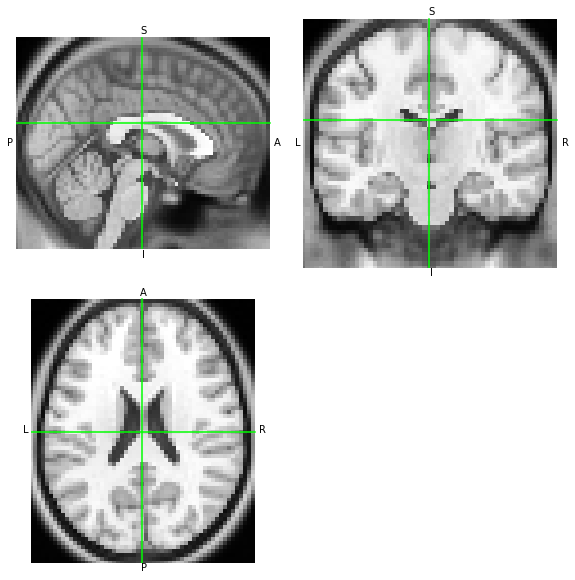

In [3]:
# Load the example
nii = nb.load('someones_anatomy.nii.gz')
hdr = nii.header.copy()
aff = nii.affine.copy()
data = nii.get_data()

nii.orthoview()

In [4]:
# Create LAS version
las_aff = aff.copy()
las_aff[0, 0] *= -1.0
las_aff[0, 3] = aff.dot(np.hstack((np.array(nii.shape[:3]) - 1, 1.0)))[0]

las = nb.Nifti1Image(np.flip(data, 0), las_aff, nii.header)
las.to_filename('someones_anatomy_LAS.nii.gz')

# Create LPS version
lps_aff = aff.copy()
lps_aff[0, 0] *= -1.0
lps_aff[1, 1] *= -1.0
lps_aff[:2, 3] = aff.dot(np.hstack((np.array(nii.shape[:3]) - 1, 1.0)))[:2]

lps = nb.Nifti1Image(np.flip(np.flip(data, 0), 1), lps_aff, nii.header)
lps.to_filename('someones_anatomy_LPS.nii.gz')

# Create version not aligned to canonical
R = nb.affines.from_matvec(nb.eulerangles.euler2mat(x=0.09, y=0.001, z=0.001))
new_aff = R.dot(aff)
new = nb.Nifti1Image(data, new_aff, hdr)
new.header.set_qform(new_aff, 1)
new.header.set_sform(new_aff, 1)
new.to_filename('someones_anatomy_rot.nii.gz')

In [5]:
M = nb.affines.from_matvec(nb.eulerangles.euler2mat(x=0.09, y=0.001, z=0.001), [4.0, 2.0, -1.0])

In [6]:
xfm = nb.transform.linear.Affine(M)
xfm.matrix

array([[ 9.99999000e-01, -9.99999333e-04,  9.99999833e-04,
         4.00000000e+00],
       [ 1.08583106e-03,  9.95952145e-01, -8.98785043e-02,
         2.00000000e+00],
       [-9.06073535e-04,  8.98795002e-02,  9.95952235e-01,
        -1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [7]:
xfm.reference = nb.load('someones_anatomy_rot.nii.gz')
moved = xfm.resample(new)
moved.to_filename('moved-nb.nii.gz')

<OrthoSlicer3D: moved-nb.nii.gz (57, 67, 56)>

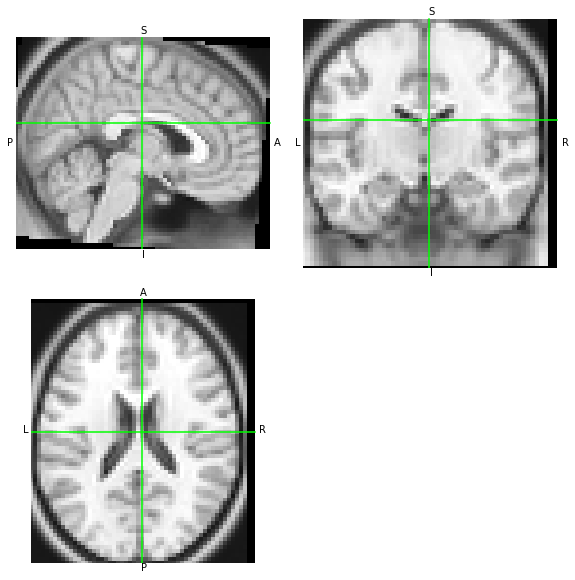

In [8]:
moved.orthoview()

In [9]:
xfm.to_filename('M.tfm', fmt='itk')
xfm.to_filename('M.fsl', fmt='fsl')
xfm.to_filename('M.afni', fmt='afni')

'M.afni'

In [10]:
!antsApplyTransforms -d 3 -i 'someones_anatomy_rot.nii.gz' -r 'someones_anatomy_rot.nii.gz' -o 'moved-itk.nii.gz' -n 'BSpline' -t 'M.tfm' --float

<OrthoSlicer3D: moved-itk.nii.gz (57, 67, 56)>

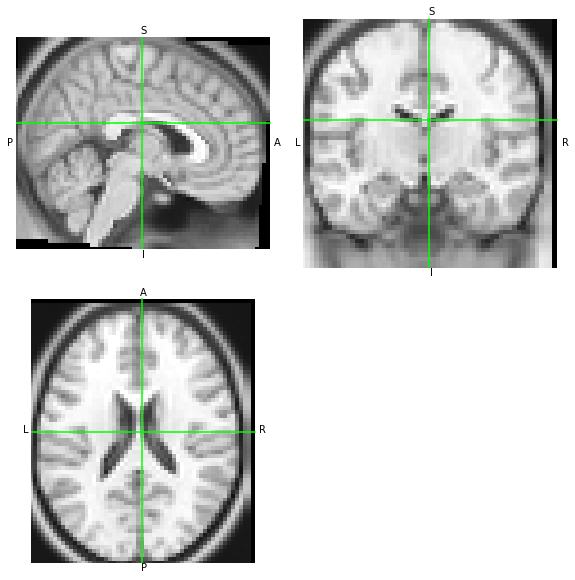

In [11]:
nb.load('moved-itk.nii.gz').orthoview()

In [12]:
!flirt -in someones_anatomy_rot.nii.gz -ref someones_anatomy_rot.nii.gz -out moved-fsl.nii.gz -init M.fsl -applyxfm

<OrthoSlicer3D: moved-fsl.nii.gz (57, 67, 56)>

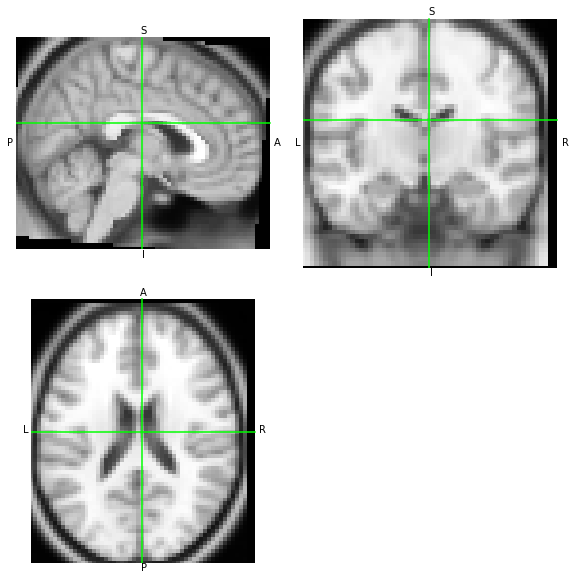

In [13]:
nb.load('moved-fsl.nii.gz').orthoview()

In [14]:
!3dAllineate -base someones_anatomy_rot.nii.gz -source someones_anatomy_rot.nii.gz -1Dmatrix_apply M.afni -prefix moved-afni -final cubic
!3dAFNItoNIFTI moved-afni+orig
!gzip moved-afni.nii

++ 3dAllineate: AFNI version=AFNI_16.0.01 (Jan 27 2016) [64-bit]
++ Authored by: Zhark the Registrator
** AFNI converts NIFTI_datatype=2 (UINT8) in file someones_anatomy_rot.nii.gz to FLOAT32
     Warnings of this type will be muted for this session.
     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
*+ WARNING:   If you are performing spatial transformations on an oblique dset, 
  such as someones_anatomy_rot.nii.gz,
  or viewing/combining it with volumes of differing obliquity,
  you should consider running: 
     3dWarp -deoblique 
  on this and  other oblique datasets in the same session.
 See 3dWarp -help for details.
++ Oblique dataset:someones_anatomy_rot.nii.gz is 5.156967 degrees from plumb.
++ Oblique dataset:someones_anatomy_rot.nii.gz is 5.156967 degrees from plumb.
++ Source dataset: ./someones_anatomy_rot.nii.gz
++ Base dataset:   ./someones_anatomy_rot.nii.gz
++ You might want to use '-master' when using '-1D*_apply'
++ Loading datasets
++ master datas

<OrthoSlicer3D: moved-afni.nii.gz (57, 67, 56)>

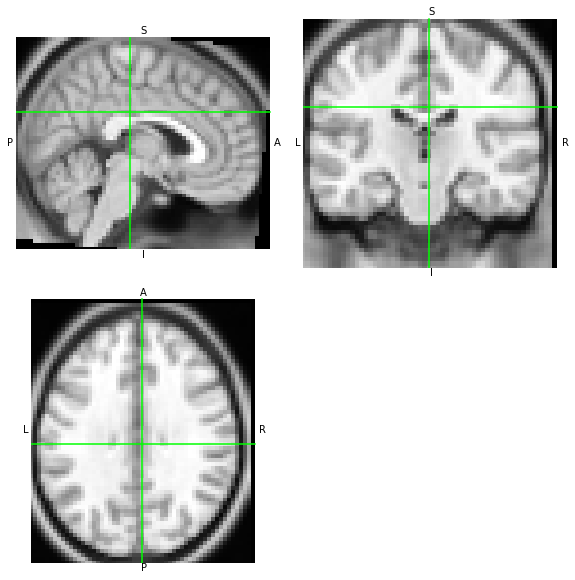

In [15]:
nb.load('moved-afni.nii.gz').orthoview()